# SENTIMENT ANALYSIS - AMAZON PHONES DATASET

### Library imports

In [ ]:
#!pip install -r requirements.txt
#!python -m spacy download en
#!pip install transformers
!pip install -U scikit-learn

In [44]:
!pip uninstall torch torchvision torchaudio

^C


In [45]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

^C


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import preprocessing_helpers as preprocessing_helpers

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### Loading dataset

In [7]:
dataset = pd.read_csv("Amazon_Unlocked_Mobile.csv", index_col=False)

### Dataset review

In [8]:
dataset.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [9]:
dataset.describe()

,Price,Rating,Review Votes
count,407907.000000,413840.000000,401544.000000
mean,226.867155,3.819578,1.507237
std,273.006259,1.548216,9.163853
min,1.730000,1.000000,0.000000
25%,79.990000,3.000000,0.000000
50%,144.710000,5.000000,0.000000
75%,269.990000,5.000000,1.000000
max,2598.000000,5.000000,645.000000


In [10]:
dataset = dataset[['Rating', 'Reviews']]
dataset.dropna(inplace=True)

dataset['Label'] = dataset['Rating'].apply(preprocessing_helpers.Encode_rating) 

dataset['CleanReviews'] = dataset['Reviews'].apply(preprocessing_helpers.Removing_url)

dataset['CleanReviews'] = dataset['CleanReviews'].apply(preprocessing_helpers.Convert_to_lowercase)

dataset['CleanReviews'] = dataset['CleanReviews'].apply(preprocessing_helpers.Clean_non_alphanumeric)

In [11]:
dataset.head()

,Rating,Reviews,Label,CleanReviews
0,5,I feel so LUCKY to have found this used (phone...,Positive,i feel so lucky to have found this used phone...
1,4,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice up grade from my pantach revu...
2,5,Very pleased,Positive,very pleased
3,4,It works good but it goes slow sometimes but i...,Positive,it works good but it goes slow sometimes but i...
4,4,Great phone to replace my lost phone. The only...,Positive,great phone to replace my lost phone the only...


<Axes: xlabel='count', ylabel='Rating'>

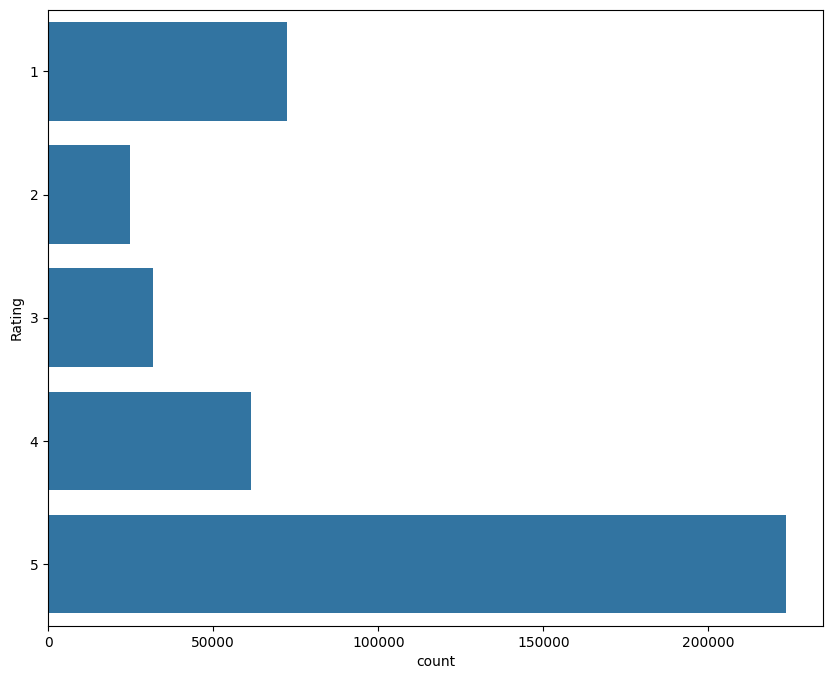

In [12]:
plt.figure(figsize=(10,8))
sns.countplot(y='Rating', data=dataset)

In [13]:
dataset_filtered = dataset[['Label', 'CleanReviews']]


### Checking for device

In [42]:
import torch

# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
#device = torch.device("cpu")

No GPU available, using the CPU instead.


In [20]:
# import packages
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector


# load english vocab and create pipeline 
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)


# use created pipeline for language detect
def detect_lan(text) :
    doc = nlp(text)
    detect_language = doc._.language 
    detect_language = detect_language['language']
    return(detect_language)

In [21]:
#dataset_filtered['Reviews_language'] = dataset_filtered['CleanReviews'].apply(lambda x: detect_lan(x))


In [22]:
#dataset_filtered.to_csv("Amazon_Unlocked_Mobile_filtered.csv", index=False)

In [23]:
dataset.head()

,Rating,Reviews,Label,CleanReviews
0,5,I feel so LUCKY to have found this used (phone...,Positive,i feel so lucky to have found this used phone...
1,4,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice up grade from my pantach revu...
2,5,Very pleased,Positive,very pleased
3,4,It works good but it goes slow sometimes but i...,Positive,it works good but it goes slow sometimes but i...
4,4,Great phone to replace my lost phone. The only...,Positive,great phone to replace my lost phone the only...


## Model loading

In [26]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')


d:\ELFAK Filip\MASTER - X SEMESTAR\Obrada prirodnih jezika\Projekat - Sentiment Analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
print({x : tokenizer.encode(x, add_special_tokens=False) for x in dataset_filtered.CleanReviews.values[0].split()})

{'i': [17], 'feel': [12319], 'so': [221], 'lucky': [138009], 'to': [47], 'have': [765], 'found': [14037], 'this': [903], 'used': [11814], 'phone': [24089], 'us': [1821], 'not': [959], 'hard': [7941], 'at': [99], 'all': [756], 'on': [98], 'line': [13315], 'from': [1295], 'someone': [22008], 'who': [2750], 'upgraded': [116086, 71], 'and': [136], 'sold': [54324], 'one': [1632], 'my': [759], 'son': [775], 'liked': [1884, 71], 'his': [1919], 'old': [10332], 'that': [450], 'finally': [77681], 'fell': [77736], 'apart': [34955], 'after': [7103], 'years': [5369], 'didn': [15935], 't': [808], 'want': [3444], 'an': [142], 'upgrade': [116086], 'thank': [51544], 'you': [398], 'seller': [7666, 42], 'we': [642], 'really': [6183], 'appreciate': [77947], 'it': [442], 'your': [935], 'honesty': [42551, 53], 're': [456], 'said': [2804], 'recommend': [67330], 'very': [4552], 'highly': [103210], 'would': [2806], 'but': [1284], 'them': [2856], 'again': [13438]}


In [28]:
tokenizer(dataset_filtered.CleanReviews.values[0])['input_ids']


[0,
 17,
 12319,
 221,
 138009,
 47,
 765,
 14037,
 903,
 11814,
 24089,
 47,
 1821,
 959,
 11814,
 7941,
 99,
 756,
 24089,
 98,
 13315,
 1295,
 22008,
 2750,
 116086,
 71,
 136,
 54324,
 903,
 1632,
 759,
 775,
 1884,
 71,
 1919,
 10332,
 1632,
 450,
 77681,
 77736,
 34955,
 7103,
 5369,
 136,
 15935,
 808,
 3444,
 142,
 116086,
 51544,
 398,
 7666,
 42,
 642,
 6183,
 77947,
 442,
 935,
 42551,
 53,
 456,
 2804,
 11814,
 24089,
 17,
 67330,
 903,
 7666,
 42,
 4552,
 103210,
 2806,
 1284,
 1295,
 2856,
 13438,
 2]

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


max:  5941
min:  2


(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000., 400000., 450000.]),
 [Text(0, 0.0, '0'),
  Text(0, 50000.0, '50000'),
  Text(0, 100000.0, '100000'),
  Text(0, 150000.0, '150000'),
  Text(0, 200000.0, '200000'),
  Text(0, 250000.0, '250000'),
  Text(0, 300000.0, '300000'),
  Text(0, 350000.0, '350000'),
  Text(0, 400000.0, '400000'),
  Text(0, 450000.0, '450000')])

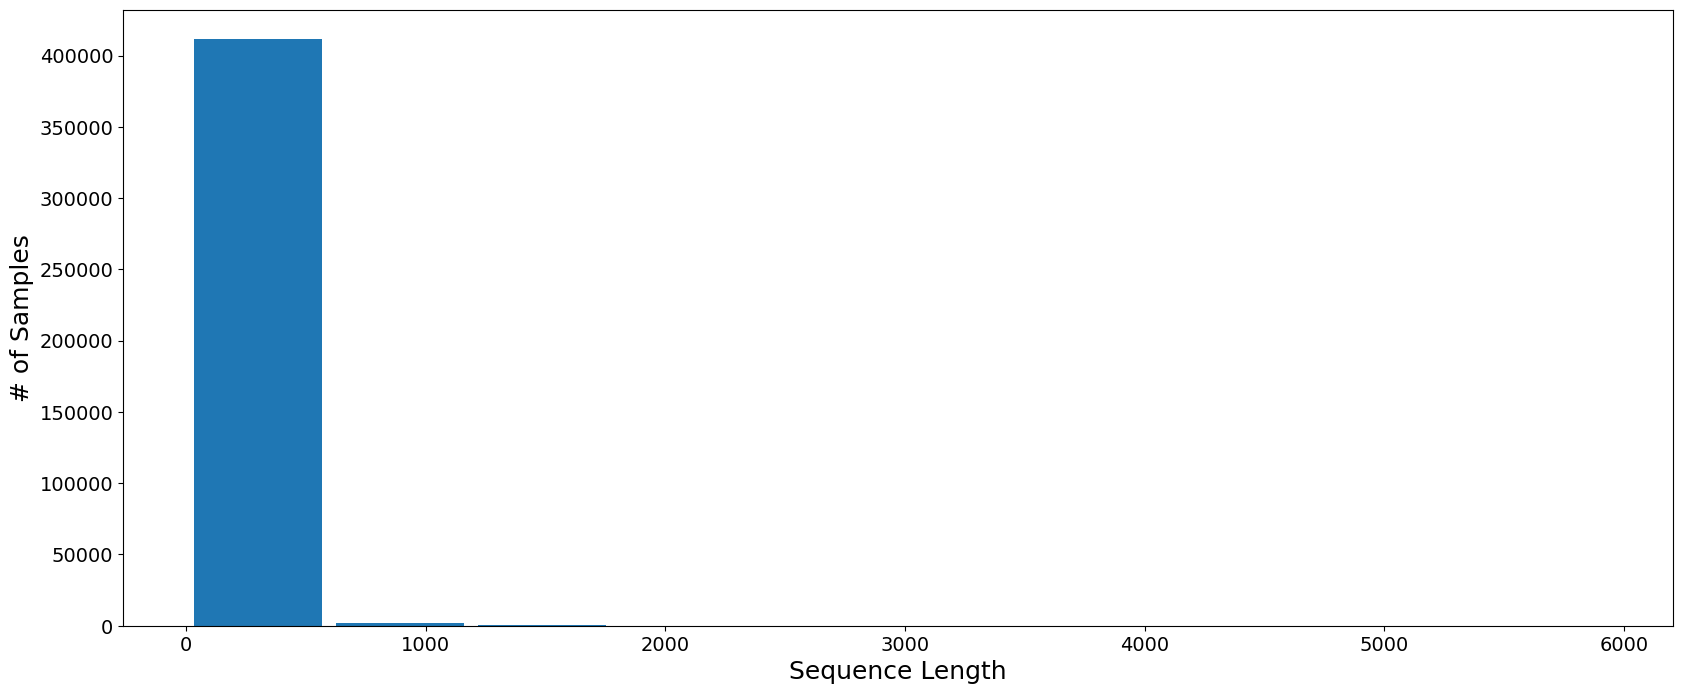

In [29]:
# tokenize the text feature 
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            dataset_filtered.CleanReviews.values.tolist(), 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(0, 50000)

### Defining features and targets

In [30]:
# identify features and target
features = dataset_filtered.CleanReviews.values.tolist()
target = dataset_filtered.Label.values.tolist()

### Tokenizing features

In [31]:
# tokenize features 
MAX_LEN = 128
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'       
                   )

In [32]:
print("Dict keys: ", tokenized_feature.keys())

print("Shape of input_ids values: ", tokenized_feature['input_ids'].shape)

print("Shape of attention_mask values: ", tokenized_feature['attention_mask'].shape)

Dict keys:  dict_keys(['input_ids', 'attention_mask'])
Shape of input_ids values:  torch.Size([413770, 128])
Shape of attention_mask values:  torch.Size([413770, 128])


### Encoding target feature

In [35]:
# convert label into numeric 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)

In [36]:
target_num

array([2, 2, 2, ..., 2, 1, 2])

### Splitting dataset

In [37]:
# Use 80% for training and 20% for validation
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(tokenized_feature['input_ids'], 
                                                                                                             target_num,
                                                                                                                    tokenized_feature['attention_mask'],
                                                                                                      random_state=2018, test_size=0.2, stratify=target)

In [38]:
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Setup the model 

In [39]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = len(set(target)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

# Receive the full size of the new word
model.resize_token_embeddings(len(tokenizer))

# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

model.safetensors: 100%|██████████| 1.12G/1.12G [01:45<00:00, 10.6MB/s]
d:\ELFAK Filip\MASTER - X SEMESTAR\Obrada prirodnih jezika\Projekat - Sentiment Analysis\.venv\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Legion\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warn

In [40]:
# Number of training epochs
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## Training the model

In [43]:
# Training
import time
# Store the average loss after each epoch 
loss_values = []
# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / batch_size)
# looping over epochs
for epoch_i in range(0, epochs):
    
    print('training on epoch: ', epoch_i)
    # set start time 
    t0 = time.time()
    # reset total loss
    total_loss = 0
    # model in training 
    model.train()
    # loop through batch 
    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 step 
        if step % 50 == 0 and not step == 0:
            print('training on step: ', step)
            print('total time used is: {0:.2f} s'.format(time.time() - t0))
        # load data from dataloader 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # clear any previously calculated gradients 
        model.zero_grad()
        # get outputs
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        # get loss
        loss = outputs[0]
        # total loss
        total_loss += loss.item()
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update optimizer
        optimizer.step()
        # update learning rate 
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("average training loss: {0:.2f}".format(avg_train_loss))

total steps per epoch:  1293.0625
training on epoch:  0


RuntimeError: expected scalar type Long but found Int

## Testing model

In [ ]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

In [ ]:
# convert numeric label to string
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))